# 문자-단위 RNN으로 이름 분류하기
- 코드 출처: https://tutorials.pytorch.kr/intermediate/char_rnn_classification_tutorial.html

## 데이터 처리

### 데이터 다운로드
* 나라명.txt 파일 안에 한 줄씩 그 나라사람 이름이 들어가있다.

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2024-09-01 09:44:36--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.238.238.82, 18.238.238.104, 18.238.238.114, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.238.238.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.05s   

2024-09-01 09:44:36 (50.2 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/

In [2]:
# 18개의 나라

import glob
import os

all_categories = []

def findFiles(path):
    return glob.glob(path)

for filename in findFiles('data/names/*.txt'):
    # os.path.basename(filename) : 파일명만 가져옴 <- Spanish.txt
    # os.path.splitext(Spanish.txt) : 확장자로 분리 <- Spanish, .txt
    category = os.path.splitext(os.path.basename(filename))[0]

    all_categories.append(category)
n_categories = len(all_categories)

all_categories, n_categories

(['Italian',
  'Russian',
  'Portuguese',
  'Chinese',
  'Polish',
  'English',
  'Dutch',
  'Japanese',
  'Greek',
  'Spanish',
  'German',
  'Vietnamese',
  'French',
  'Arabic',
  'Irish',
  'Czech',
  'Korean',
  'Scottish'],
 18)

In [3]:
# 한줄에 하나씩 이름 저장

# 파일 경로 설정
file_path = 'data/names/Spanish.txt'

# 파일 읽기
content = open(file_path, 'r', encoding='utf-8').read().strip()
# 위와 동일한 코드
# with open(file_path, 'r', encoding='utf-8') as file:
#     content = file.read().strip()

content

"Abana\nAbano\nAbarca\nAbaroa\nAbascal\nAbasolo\nAbel\nAbelló\nAberquero\nAbreu\nAcosta\nAgramunt\nAiza\nAlamilla\nAlbert\nAlbuquerque\nAldana\nAlfaro\nAlvarado\nÁlvarez\nAlves\nAmador\nAndreu\nAntúnez\nAqua\nAquino\nAraújo\nAraullo\nAraya\nArce\nArechavaleta\nArena\nAritza\nArmando\nArreola\nArriola\nAsis\nAsturias\nAvana\nAzarola\nBanderas\nBarros\nBasurto\nBautista\nBello\nBelmonte\nBengochea\nBenitez\nBermúdez\nBlanco\nBlanxart\nBolívar\nBonaventura\nBosque\nBustillo\nBusto\nBustos\nCabello\nCabrera\nCampo\nCampos\nCapello\nCardona\nCaro\nCasales\nCastell\nCastellano\nCastillion\nCastillo\nCastro\nChavarría\nChavez\nColón\nCosta\nCrespo\nCruz\nCuéllar\nCuevas\nD'cruz\nD'cruze\nDe la cruz\nDe la fuente\nDel bosque\nDe leon\nDelgado\nDel olmo\nDe santigo\nDíaz\nDominguez\nDuarte\nDurante\nEchevarría\nEcheverría\nElizondo\nEscamilla\nEscárcega\nEscarrà\nEsparza\nEspina\nEspino\nEspinosa\nEspinoza\nEstévez\nEtxebarria\nEtxeberria\nFélix\nFernández\nFerrer\nFierro\nFlores\nFonseca\nFran

In [4]:
# 나라파일 당 이름수

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    print(f'{category} : {len(lines)}')

Italian : 709
Russian : 9408
Portuguese : 74
Chinese : 268
Polish : 139
English : 3668
Dutch : 297
Japanese : 991
Greek : 203
Spanish : 298
German : 724
Vietnamese : 73
French : 277
Arabic : 2000
Irish : 232
Czech : 519
Korean : 94
Scottish : 100


### 데이터 전처리
* unicode(Ślusàrski) -> ascii(Slusarski)
* category_lines = {category : [이름1, 이름2, ...], ...}

In [5]:
# unicode로 저장된 걸 ascii 로 바꿔준다

import unicodedata
import string

# ascii 에 사용되는 글자수 <- 이게 나중에 하나하나가 one-hot으로 처리된다
all_letters = string.ascii_letters + " .,:'"
n_letters = len(all_letters)
all_letters, n_letters

("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,:'", 57)

In [6]:
# https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

print(f'unicode : Ślusàrski \nascii : {unicodeToAscii("Ślusàrski")}')

unicode : Ślusàrski 
ascii : Slusarski


In [13]:
from io import open
import os
import glob

# txt파일에 있는 이름에 unicode to ascii를 적용
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# category : [이름1, 이름2, ...]
category_lines = {}
all_categories = []

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
n_categories = len(all_categories)

In [15]:
print(category_lines['Spanish'][:5])

['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal']


In [16]:
print(category_lines['Korean'][:5])

['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']


### tensor화
* 문자 하나당 one-hot encoding
* 단어 = 문자 하나하나가 batch크기1로 들어간 batch묶음

In [17]:
# all_letters에 있는 문자 하나하나가 index위치를 차지
# 'J'를 one-hot으로 나타내면, 'J'번째인 35번째가 1로 바뀜

import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    # 첫번째 차원을 1로 해서, 2차원으로 만들어준다.
    # 신경망에서는 1차원으로 들어가지 않고, 2차원으로 들어가기 때문
    # ex. fc : Linear(100,10) = (2,100) -> (2,10)
    # batch 안에 1개 문자(batch크기=1)
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

print(all_letters, '\n\n', letterToTensor('J'))

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,:' 

 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [18]:
def lineToTensor(line): # one-hot
    tensor = torch.zeros(len(line), 1, n_letters) # 단어를 이루는 문자수로 첫번째 차원을 확장 <- 5개의 batch
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(lineToTensor('Jones'), '\n') # J, o, n, e, s 차례대로 변환됨
print(lineToTensor('Jones').size()) # batch크기가 1인게, 5개의 batch로 들어감.

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

## 네트워크 생성

<img src="https://github.com/ksouth0413/dltutorial/raw/main/PyTorch%20KR/photo/rnn(1).jpeg" height="300">

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):

    # CNN : 한 batch안에 8개의 동일한 크기 이미지(28x28)가 묶여있다.
    # RNN : 한 batch안에 1개의 문자가 들어간다. 'Albert'는 batchsize가 1인 batch가 6개 모여있다.

    # 즉, cnn은 한 batch의 데이터들이 따로 들어가서, 각각을 backpropagation하고 grad의 평균으로 weight-update
    # rnn은 batch인 'A','l','b','e'... 이 순차적으로 들어가서 결국 Albert가 다 들어가야
    # output이 나와 loss계산이 가능하고 이를 통해 backpropagation이 가능하다.
    # 즉, sequence별로 처리

    # cnn과 달리, size를 argument로 미리 받는다.
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    # 단어(시퀀스)가 달라질 때마다, hidden을 다시 0으로 초기화
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [20]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

n_letters, n_hidden, n_categories

(57, 128, 18)

In [21]:
for p in rnn.parameters():
    print(p.data.shape)

torch.Size([128, 57])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([18, 128])
torch.Size([18])


<img src="https://github.com/ksouth0413/dltutorial/raw/main/PyTorch%20KR/photo/rnn(2).jpeg" height="300">

In [22]:
input = letterToTensor('C')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

input.shape, hidden.shape, output.shape

(torch.Size([1, 57]), torch.Size([1, 128]), torch.Size([1, 18]))

In [23]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

for i in range(input.size()[0]):
    output, hidden = rnn(input[i], hidden)
    print(input[i].shape, hidden.shape, output.shape)

torch.Size([1, 57]) torch.Size([1, 128]) torch.Size([1, 18])
torch.Size([1, 57]) torch.Size([1, 128]) torch.Size([1, 18])
torch.Size([1, 57]) torch.Size([1, 128]) torch.Size([1, 18])
torch.Size([1, 57]) torch.Size([1, 128]) torch.Size([1, 18])
torch.Size([1, 57]) torch.Size([1, 128]) torch.Size([1, 18])
torch.Size([1, 57]) torch.Size([1, 128]) torch.Size([1, 18])


## DataLoader와 비슷한 역할을 하는 함수 설정
- (나라,이름) 순서쌍을 랜덤 추출
- 추출한 쌍을 tensor화

In [24]:
# output벡터(1x36)을 likelihood 벡터로 생각
# 따라서 가장 높은 likelihood값으로 estimator 선택

def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # output의 가장 큰 값, index
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Japanese', 7)


In [25]:
import random

# 리스트의 값 중에 하나 랜덤 선택
def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

# 랜덤으로 국가-이름 쌍을 하나 가져오고, tensor화까지 진행
def randomTrainingExample():
    # 국가
    category = randomChoice(all_categories)
    # 이름(성)
    line = randomChoice(category_lines[category])
    # 국가 label encoding
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    # 이름 one-hot encoding
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

category, line, category_tensor, line_tensor = randomTrainingExample()

print(f'category : {category} -> {category_tensor}')
print(f'line : {line} -> {line_tensor.shape}')

category : Portuguese -> tensor([2])
line : D'cruze -> torch.Size([7, 1, 57])


In [26]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Russian / line = Tsvigun
category = German / line = Muller
category = Portuguese / line = Pinheiro
category = French / line = Couture
category = Scottish / line = Russell
category = Dutch / line = Schuyler
category = Korean / line = Yeon
category = Spanish / line = Juarez
category = English / line = Addison
category = Czech / line = Monfort


## 손실함수
* 마지막 단에 LogSoftmax()를 사용하니까
* Negative Log-Likelihood Loss인 NLLLoss()를 사용한다.

In [27]:
# likelihood를 최대화하는 estimator를 찾아야하는데
# 최적화에서 loss는 보통 최소화를 하니, negative이고
# 값의 크기를 줄이기 위해 log를 적용한다.

criterion = nn.NLLLoss()
criterion

NLLLoss()

## 학습함수 train 정의

In [28]:
learning_rate = 0.005 # 높으면 발산, 낮으면 학습안됨

def train(category_tensor, line_tensor): # y, X

    # 단어쌍(나라-이름)이 새로 들어올 때마다
    hidden = rnn.initHidden() # hidden-input값을 0으로 초기화
    rnn.zero_grad() # backprop 추적 초기화

    # cnn은 batch단위로 들어가지만
    # 이번 rnn에서는 batch크기가 1이라, seqence단위(여기서는 batch들)로 들어간다.
    for i in range(line_tensor.size()[0]): # 이름의 문자가 하나씩 들어간다.
        output, hidden = rnn(line_tensor[i], hidden)

    # 단어의 모든 문자가 들어가야, 결과값인 output과 실제값인 y를 통해 loss계산
    loss = criterion(output, category_tensor)
    # 계산된 loss를 바탕으로 grad 계산
    loss.backward()

    # 가중치 업데이트
    # weight = weight + grad * -lr
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate) # add_(inplace연산) vs add(비inplace연산)

    return output, loss.item()

In [29]:
category, line, category_tensor, line_tensor = randomTrainingExample()

# 이걸 해줘야 이전에 들어간 hidden값이 초기화된다.
# 이전 값은 grad로 이미 backprop이 진행되어 있을 수 있다.
# 따라서 없이 진행하면 아래 loss.backward()에서 backprop을 하는거라, 초기화 필요함
hidden = rnn.initHidden()
rnn.zero_grad()

# backprop전
for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
loss = criterion(output, category_tensor)
for p in rnn.parameters():
    print(f'전 : weight {p.data.shape}, grad {p.grad}') # backprop을 하지 않아, None이 저장
print()

# backprop후
loss.backward()
for p in rnn.parameters():
    print(f'후 : weight {p.data.shape}, grad {p.grad.shape}') # backprop을 해서 weight에 대응하는 grad가 생성

전 : weight torch.Size([128, 57]), grad None
전 : weight torch.Size([128]), grad None
전 : weight torch.Size([128, 128]), grad None
전 : weight torch.Size([128]), grad None
전 : weight torch.Size([18, 128]), grad None
전 : weight torch.Size([18]), grad None

후 : weight torch.Size([128, 57]), grad torch.Size([128, 57])
후 : weight torch.Size([128]), grad torch.Size([128])
후 : weight torch.Size([128, 128]), grad torch.Size([128, 128])
후 : weight torch.Size([128]), grad torch.Size([128])
후 : weight torch.Size([18, 128]), grad torch.Size([18, 128])
후 : weight torch.Size([18]), grad torch.Size([18])


In [30]:
print(f'prev-weight : {p.data[:2]}')
print(f'grad : {p.grad[:2]}\n')

learning_rate = 1

print(f'later-weight : {p.data.add_(p.grad.data, alpha=-learning_rate)[:2]}')

prev-weight : tensor([-0.0051,  0.0670])
grad : tensor([0.0592, 0.0543])

later-weight : tensor([-0.0643,  0.0127])


In [31]:
import numpy as np

print(f'원래 : {np.round(p.data[0].item(),4)}')
p.data.add(p.grad.data, alpha=-learning_rate)
print(f'언더바없이 : {np.round(p.data[0].item(),4)}')
p.data.add_(p.grad.data, alpha=-learning_rate)
print(f'언더바사용 : {np.round(p.data[0].item(),4)}')

원래 : -0.0643
언더바없이 : -0.0643
언더바사용 : -0.1234


In [32]:
# 다시 불러오기

learning_rate = 0.005

def train(category_tensor, line_tensor):

    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

## 실제 학습

In [33]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since # 차이나는 시간(단위:초)
    m = math.floor(s / 60) # 단위 : 초->분
    s -= m * 60 # 나머지 : 초
    return '%dm %ds' % (m, s)

# 학습 시작시간
start = time.time()

current_loss = 0
all_losses = []

# (국가,이름) 쌍을 총 10만개 학습한다.
n_iters = 10**5
print_every = 5*10**3
plot_every = 10**3

for iter in range(1, n_iters + 1):
    # 입력값 = (국가,이름) 쌍
    category, line, category_tensor, line_tensor = randomTrainingExample()
    # 입력값을 토대로 나온 output벡터와 loss값
    output, loss = train(category_tensor, line_tensor)
    # plot_every인 1,000번 동안 나온 loss를 합한다.
    current_loss += loss

    # 5,000번 마다 답이 맞는지 확인
    if iter % print_every == 0:
        # output값을 토대로 '국가'를 예측한다.
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f,  %s / %s %s' % (iter, iter/n_iters*100, timeSince(start), loss, line, guess, correct))

    # 1,000번 마다 구간안에서의 loss합을 확인
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every) # 1,000개 단어 loss 평균
        current_loss = 0

5000 5% (0m 7s) 3.1480,  Ola / Korean ✗ (Spanish)
10000 10% (0m 15s) 2.5840,  Olivier / German ✗ (French)
15000 15% (0m 22s) 3.4997,  Lucas / Arabic ✗ (Dutch)
20000 20% (0m 30s) 2.2432,  Belanger / German ✗ (French)
25000 25% (0m 38s) 2.7950,  Hughes / Dutch ✗ (Scottish)
30000 30% (0m 45s) 2.6316,  Korycan / Dutch ✗ (Czech)
35000 35% (0m 53s) 1.6469,  Moreno / Spanish ✗ (Portuguese)
40000 40% (1m 0s) 2.7882,  Bolivar / French ✗ (Spanish)
45000 45% (1m 8s) 2.3863,  Chu / Vietnamese ✗ (Korean)
50000 50% (1m 16s) 3.1943,  Ludwig / Russian ✗ (German)
55000 55% (1m 23s) 1.5707,  Ferrero / Spanish ✗ (Italian)
60000 60% (1m 31s) 0.6417,  Brodeur / French ✓
65000 65% (1m 38s) 0.2480,  Sinclair / Scottish ✓
70000 70% (1m 45s) 0.2211,  Fan / Chinese ✓
75000 75% (1m 55s) 0.4635,  Vela / Spanish ✓
80000 80% (2m 2s) 3.7706,  Salomon / French ✗ (Polish)
85000 85% (2m 9s) 0.5045,  Avksentievsky / Russian ✓
90000 90% (2m 17s) 0.9069,  Antwerp / Dutch ✓
95000 95% (2m 24s) 2.5684,  Rhodes / Dutch ✗ (Eng

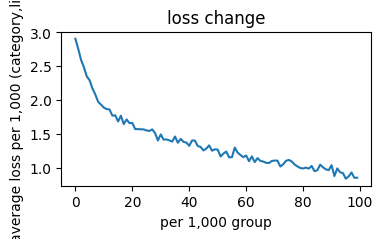

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


plt.figure(figsize=(4,2))
plt.plot(all_losses)
plt.xlabel('per 1,000 group')
plt.ylabel('average loss per 1,000 (category,line)')
plt.title('loss change')
plt.show()

## 결과 평가

<ipython-input-35-36d5c3774337>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-35-36d5c3774337>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


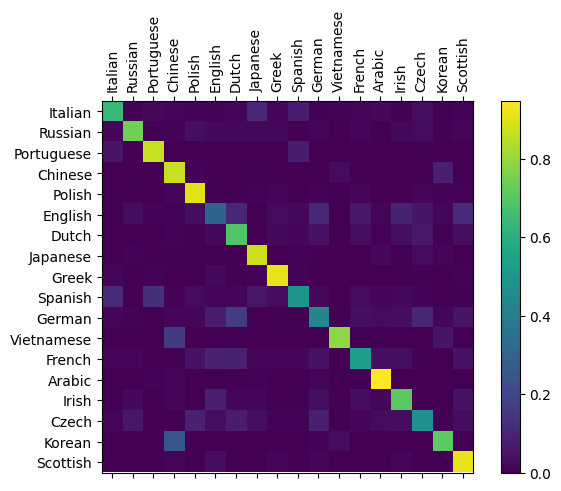

In [35]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 학습된 모델을 사용하고자 한다.
# 입력이 주어지면, output을 뽑아내는 함수
# 단, weight는 학습하지 않고 학습된 상태거를 사용.(아래cell의 train과 다름)
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 10,000개의 데이터들을 가지고 평가
for i in range(n_confusion):
    # 데이터를 하나씩 랜덤으로 선택
    category, line, category_tensor, line_tensor = randomTrainingExample()
    # 학습된 모델로 output벡터 획득
    output = evaluate(line_tensor)
    # output벡터로부터 가장 높은 likelihood값을 가지는 category값 획득
    guess, guess_i = categoryFromOutput(output)
    # category index
    category_i = all_categories.index(category)
    # confusion matrix 제작 : (실제정답, 추정한정답)
    confusion[category_i][guess_i] += 1

# 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 시각화
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

* 가로 : 추정값
* 세로 : 정답 <br>

주축에서 벗어난 밝은 점을 선택하여 잘못 추측한 언어를 표시할 수 있습니다. 예를 들어 한국어는 중국어로 이탈리아어로 스페인어로. 그리스어는 매우 잘되는 것으로 영어는 매우 나쁜 것으로 보입니다. (다른 언어들과의 중첩 때문으로 추정)

In [37]:
# train부분에서 학습과 관련된 부분만 제거

# learning_rate = 0.005

def train(category_tensor, line_tensor):

    hidden = rnn.initHidden()
    # rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # loss = criterion(output, category_tensor)
    # loss.backward()

    # for p in rnn.parameters():
    #     p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

## 사용자 입력으로부터의 실행

In [36]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.38) Russian
(-1.77) Czech
(-2.72) Polish

> Jackson
(-0.08) Scottish
(-2.70) English
(-5.78) Russian

> Satoshi
(-0.08) Japanese
(-3.12) Italian
(-3.87) Greek
